<a href="https://colab.research.google.com/github/llaygh/T5_camp_Amany/blob/main/Amany_Task2_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification Exam

Welcome to the Text Classification Practical Exam. In this exam, you will be tasked with building, training, and evaluating an NLP model to classify text data. You are provided with a labeled dataset containing both the text and its corresponding class labels.

Your objective is to develop a model that accurately predicts the class of the given text. Make sure to follow best practices in data preprocessing, model selection, and evaluation to achieve optimal results.

Good luck!
___

# Install and Import Needed Libraries

In [1]:
pip install pyarabic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 8.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import pyarabic.araby as araby

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

In [4]:
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('wordnet')

import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Download the Dataset

In [5]:
!kaggle datasets download -d khaledzsa/spam-messages
!unzip spam-messages.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/spam-messages
License(s): unknown
100% 213k/213k [00:00<00:00, 399kB/s]
100% 213k/213k [00:00<00:00, 399kB/s]
Archive:  spam-messages.zip
  inflating: spam.csv                


In [6]:
df = pd.read_csv('spam.csv')

# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset.

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes).

4. **Text Data Characteristics (Bonus)**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary (Bonus)**:
   Explore the most frequent words in the text data.

In [7]:
df.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [8]:
df.isnull().sum()

,0
text,0
label,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   label   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [10]:
label_distribution = df['label'].value_counts()
label_distribution

,count
label,
ham,4825
spam,747


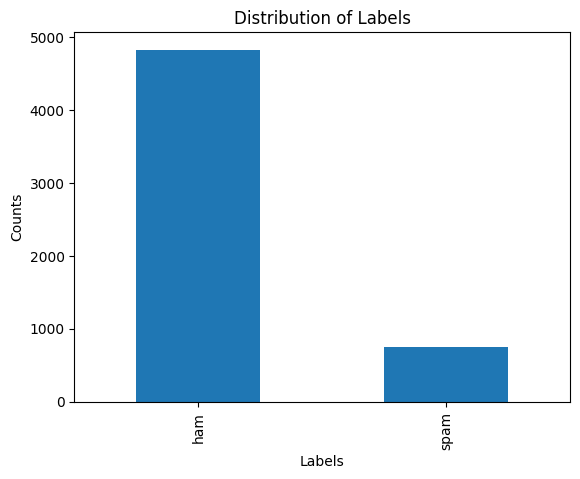

In [11]:
label_distribution.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.show()

> not balenced


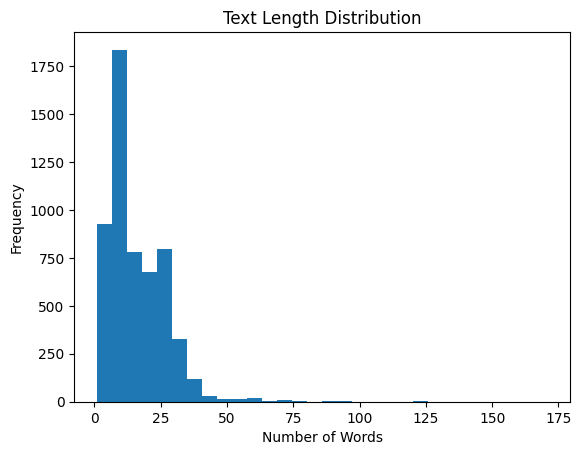

In [12]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
df['text_length'].max() # max length


# print(df['text_length'].describe())

df['text_length'].plot(kind='hist', bins=30)
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:  
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length (Bonus)**:  
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **English stopwords loading**:  
   We load a list of English stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

4. **Text cleaning**:  
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   
   - **Removing links (URLs)**:  
     Any URLs present in the text are removed as they are not meaningful for classification purposes.
   
   - **Removing special characters and punctuation**:  
     This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   
   - **Lowercasing**:  
     All text is converted to lowercase for uniformity and to avoid case sensitivity issues.
   
   - **Removing English stopwords**:  
     Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   
   - **Stemming or Lemmatization**:  
     Either stemming or lemmatization is applied to reduce words to their root or base form, ensuring consistency in word forms.

5. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

In [13]:
# lower case data frame column by column
df['text']=df['text'].str.lower()
df['label']=df['label'].str.lower()

In [14]:
# the is no null values as shown above
# so i'll start by remove the stopwords using genism
from gensim.parsing.preprocessing import remove_stopwords

df['text'] = df['text'].apply(lambda x: remove_stopwords(str(x)))

print("Original Text:", df['text'])
print("Text after Stopword Removal:", df['text'])

Original Text: 0       jurong point, crazy.. available bugis n great ...
1                           ok lar... joking wif u oni...
2       free entry 2 wkly comp win fa cup final tkts 2...
3         u dun early hor... u c say... https://link2.com
4       nah don't think goes usf, lives https://link1.com
                              ...                        
5567    2nd time tried 2 contact u. u won å£750 pound ...
5568                        ì_ b going esplanade fr home?
5569    pity, * mood that. so...any suggestions? https...
5570    guy bitching acted like i'd interested buying ...
5571                                           rofl. true
Name: text, Length: 5572, dtype: object
Text after Stopword Removal: 0       jurong point, crazy.. available bugis n great ...
1                           ok lar... joking wif u oni...
2       free entry 2 wkly comp win fa cup final tkts 2...
3         u dun early hor... u c say... https://link2.com
4       nah don't think goes usf, lives https:

In [15]:
# i was having a truple with assigning the changes to the dataframe
# so i did this loop -> to irate each column and do the changes
for i in range(len(df)):
  df['text'][i] = re.sub(r'https?://\S+|www\.\S+', '', str(df['text'][i]), flags=re.MULTILINE)
  df['text'][i] = str(df['text'][i]).translate(str.maketrans('', '', string.punctuation))

Streaming output truncated to the last 5000 lines.
<ipython-input-15-91f65d379640>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i] = re.sub(r'https?://\S+|www\.\S+', '', str(df['text'][i]), flags=re.MULTILINE)
<ipython-input-15-91f65d379640>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i] = str(df['text'][i]).translate(str.maketrans('', '', string.punctuation))
<ipython-input-15-91f65d379640>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [16]:
df['text']

,text
0,jurong point crazy available bugis n great wor...
1,ok lar joking wif u oni
2,free entry 2 wkly comp win fa cup final tkts 2...
3,u dun early hor u c say
4,nah dont think goes usf lives
...,...
5567,2nd time tried 2 contact u u won å£750 pound p...
5568,ì b going esplanade fr home
5569,pity mood that soany suggestions
5570,guy bitching acted like id interested buying w...


In [17]:
# here i tried to limmatize words using spacy
# i couldn't do it with nltk it didn't work
import spacy
nlp = spacy.load('en_core_web_sm')


doc = nlp(str(df['text']))
lemmatized_tokens = [token.lemma_ for token in doc]
lemmatized_text = ' '.join(lemmatized_tokens)


print("Original Text:", str(df['text']))
print("Lemmatized Text:", lemmatized_text)

Original Text: 0       jurong point crazy available bugis n great wor...
1                                 ok lar joking wif u oni
2       free entry 2 wkly comp win fa cup final tkts 2...
3                                u dun early hor u c say 
4                          nah dont think goes usf lives 
                              ...                        
5567    2nd time tried 2 contact u u won å£750 pound p...
5568                          ì b going esplanade fr home
5569                   pity  mood that soany suggestions 
5570    guy bitching acted like id interested buying w...
5571                                            rofl true
Name: text, Length: 5572, dtype: object
Lemmatized Text: 0        jurong point crazy available bugis n great wor ... 
 1                                  ok lar joke wif u oni 
 2        free entry 2 wkly comp win fa cup final tkts 2 ... 
 3                                 u dun early hor u c say 
 4                           nah do not think go

In [18]:
df['text']

,text
0,jurong point crazy available bugis n great wor...
1,ok lar joking wif u oni
2,free entry 2 wkly comp win fa cup final tkts 2...
3,u dun early hor u c say
4,nah dont think goes usf lives
...,...
5567,2nd time tried 2 contact u u won å£750 pound p...
5568,ì b going esplanade fr home
5569,pity mood that soany suggestions
5570,guy bitching acted like id interested buying w...


# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. You can use `Tokenizer` tokenizer from `tensorflow.keras.preprocessing.text` package or any other tokenizer you like.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form if they are not encoded.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])

sequences = tokenizer.texts_to_sequences(df['text'])

max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')# this is X

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['label']) # this is y
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')

Training data shape: (4457, 75), Training labels shape: (4457,)
Testing data shape: (1115, 75), Testing labels shape: (1115,)


In [25]:
# the distribution above shows that the data is not balanced
# one of the wayes to handle it is using SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

In [20]:
# i calculated the vocab size from the tokenz i did
vocab_size = len(tokenizer.word_index) + 1 # one for padding
vocab_size

9410

# Building the Classifier

In this step, you will design and build a NLP Classifier model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size).

4. **Bidirectional Simple RNN/LSTM Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You can chose SimpleRNN/GRU/LSTM to perform this step.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN/GRU/LSTM layers.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. Consider using appropriate activation function with appropriate number of units.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics.

In [21]:
# i will structure the model as same as we did in the class
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_length,)),  # Input layer
    tf.keras.layers.Embedding(vocab_size, 64),  # Embedding layer # vocab size
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification spam or not
])

# Summary of the model
model.summary()

# Compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 75, 64)              │         602,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 75, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 713,729 (2.72 MB)

 Trainable params: 713,729 (2.72 MB)

 Non-trainable params: 0 (0.00 B)

# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data to monitor the model’s performance on unseen data during training.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object.

In [27]:
batch_size = 10
# creating datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# Batching the Datasets
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
# training the model assigning it to histroy to plot results
history = model.fit(
    train_dataset,
    epochs=10,
    batch_size = batch_size ,
    validation_data=test_dataset,
)

Epoch 1/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9982 - loss: 0.0138 - val_accuracy: 0.1345 - val_loss: 11.3684
Epoch 2/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8788 - loss: 0.4345 - val_accuracy: 0.1345 - val_loss: 7.3603
Epoch 3/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.9299 - loss: 0.4057 - val_accuracy: 0.1345 - val_loss: 4.8607
Epoch 4/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9523 - loss: 0.2122 - val_accuracy: 0.1704 - val_loss: 4.5938
Epoch 5/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9638 - loss: 0.1488 - val_accuracy: 0.2933 - val_loss: 3.3684
Epoch 6/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9660 - loss: 0.0986 - val_accuracy: 0.2789 - val_loss: 4.3230
Epoch 7/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9833 - loss: 0.0617 - val_accuracy: 0.3067 - val_loss: 3.6750
Epoch 8/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.9886 - loss: 0.0391 -

# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset.

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs.

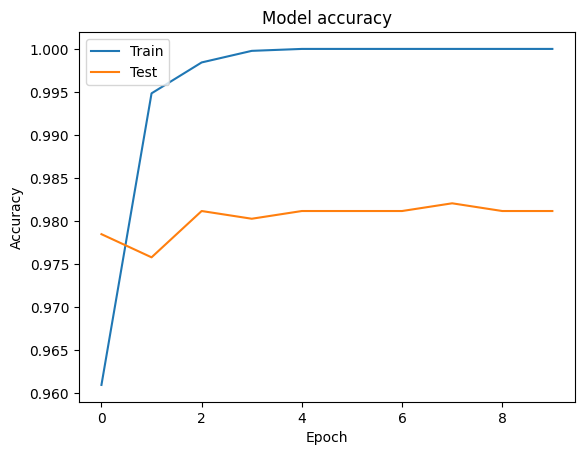

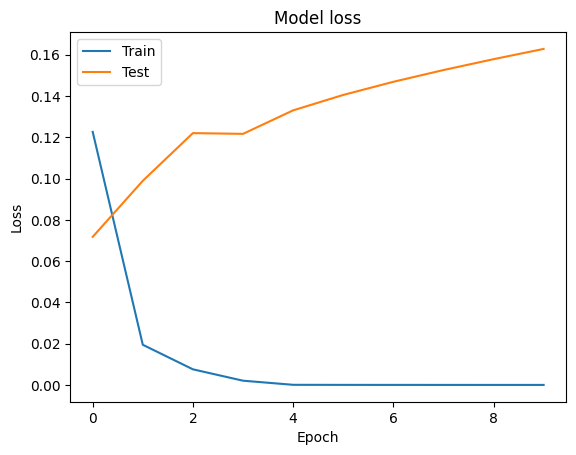

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

> this is the first run before data oversampling using SMOTE

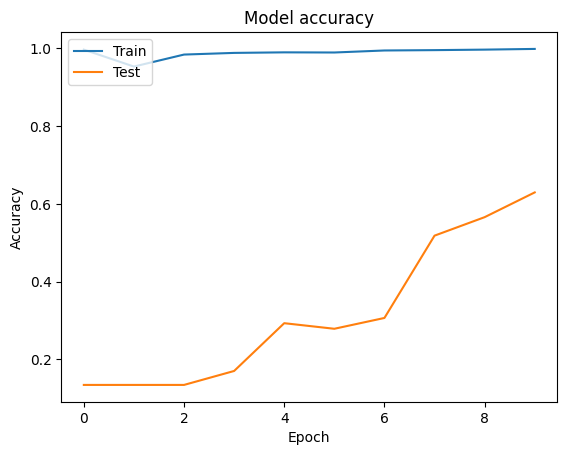

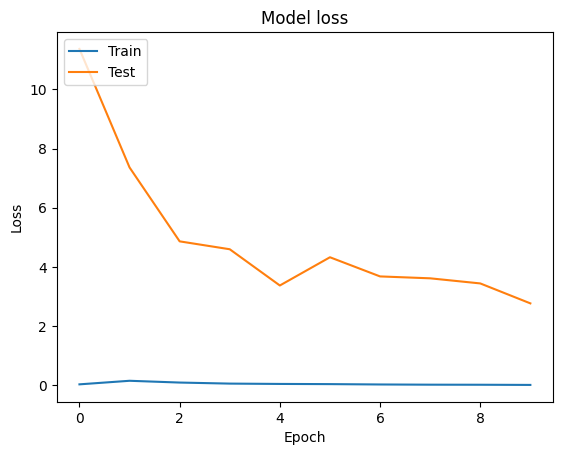

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

> this is the result after oversampling -> disappointing


# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Create Test Sample**:
   Create a string to test your modelm the goal here is to give the model Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class.

In [29]:
df[:6]

,text,label,text_length
0,jurong point crazy available bugis n great wor...,ham,20
1,ok lar joking wif u oni,ham,6
2,free entry 2 wkly comp win fa cup final tkts 2...,spam,29
3,u dun early hor u c say,ham,12
4,nah dont think goes usf lives,ham,14
5,freemsg hey darling its 3 weeks word back id l...,spam,33


In [30]:
# copy the email with the index 5
sample_text = 'freemsg hey darling its 3 weeks word back id like fun still tb ok xxx std chgs send å£150 rcv'

# Tokenize and pad the sample text
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts([sample_text])  # Fitting on the sample text to tokenize
sample_seq = tokenizer.texts_to_sequences([sample_text])
sample_padded = pad_sequences(sample_seq, maxlen=max_length, padding='post')

# Make prediction
predictions = model.predict(sample_padded)
print(*predictions[0])

# Print the label based on the prediction
if predictions[0] > 0:
    print('The email is spam')
else:
    print('The email is negative')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
0.0013480354
The email is spam


# Notebook Question:
- How did you handle text preprocessing? Why did you choose this approach?

- Why did you choose this model design?

- Why did you pick this number of layers or units for the model?

- Why did you select these evaluation methods?

- Does your model show signs of overfitting or underfitting? How do you know?

- What changes could you make to improve the model and fix overfitting or underfitting?

Answer Here:

> the results are not saticfied i there is an over fitting maybe because of imbalnced data or lake in cleaning 'needs more look up and cleaning '